# Environment Set-up

In [1]:
# Run in colab
import yfinance as yf

import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import math
import numpy as np
import random
from collections import deque
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

We first write a function to create a data frame including stock price data for the past 5 years including open, close, low, and high prices. We also add columns for the difference between open and close prices, the difference between high and low prices, and whether that month is the end of a quarter to predict the buy or not for investors.


In [2]:
def create_price_df(ticker):
    """
    ticker: the chosen company stock

    Return: returns a dataframe of a company's stock price data and features we want to use in machine learning model
    """
    price_df = price_df=yf.download(tickers = ticker, period = "5y", interval = "1d",
    prepost = False, repair = True)
    price_df["date"]=price_df.index
    price_df.reset_index()
    price_df["Date"] = price_df["date"].transform(lambda x: x.date())
    price_df["Date"] = price_df["Date"].transform(lambda x: str(x))
    price_df = price_df.drop(['date'],axis=1)
    splitted=price_df['Date'].str.split('-',expand = True)
    price_df['day'] = splitted[2].astype('int')
    price_df['month'] = splitted[1].astype('int')
    price_df['year'] = splitted[0].astype('int')
    price_df['is_quarter_end']=np.where(price_df['month']%3 == 0,1,0)
    price_df['open-close']  = price_df['Open'] - price_df['Close']
    price_df['low-high']  = price_df['Low'] - price_df['High']
    price_df['target'] = np.where(price_df['Close'].shift(-1) > price_df['Close'], 1, 0)
    #if the close price of the previous day is higher than today's close price, then the investor will buy the stock
    return price_df

In [3]:
# ticker is basically a abbreviation for a company stock.
# ticker=input("Please enter your ticker: ")
ticker="AAPL"
price_df = create_price_df(ticker = ticker)

[*********************100%%**********************]  1 of 1 completed


In [4]:
price_df

,Open,High,Low,Close,Adj Close,Volume,Repaired?,Date,day,month,year,is_quarter_end,open-close,low-high,target
Date,,,,,,,,,,,,,,,
2019-03-15,46.212502,46.832500,45.935001,46.529999,44.794376,156171600,False,2019-03-15,15,3,2019,1,-0.317497,-0.897499,1
2019-03-18,46.450001,47.097500,46.447498,47.005001,45.251671,104879200,False,2019-03-18,18,3,2019,1,-0.555000,-0.650002,0
2019-03-19,47.087502,47.247501,46.480000,46.632500,44.893051,126585600,False,2019-03-19,19,3,2019,1,0.455002,-0.767502,1
2019-03-20,46.557499,47.372501,46.182499,47.040001,45.285358,124140800,False,2019-03-20,20,3,2019,1,-0.482502,-1.190002,1
2019-03-21,47.505001,49.082500,47.452499,48.772499,46.953232,204136800,False,2019-03-21,21,3,2019,1,-1.267498,-1.630001,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-08,169.000000,173.699997,168.940002,170.729996,170.729996,76114600,False,2024-03-08,8,3,2024,1,-1.729996,-4.759995,1
2024-03-11,172.940002,174.380005,172.050003,172.750000,172.750000,60139500,False,2024-03-11,11,3,2024,1,0.190002,-2.330002,1
2024-03-12,173.149994,174.029999,171.009995,173.229996,173.229996,59825400,False,2024-03-12,12,3,2024,1,-0.080002,-3.020004,0


In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# df = pd.read_csv('GOOG-year.csv')
df = price_df
df.head()

,Open,High,Low,Close,Adj Close,Volume,Repaired?,Date,day,month,year,is_quarter_end,open-close,low-high,target
Date,,,,,,,,,,,,,,,
2019-03-15,46.212502,46.832500,45.935001,46.529999,44.794380,156171600,False,2019-03-15,15,3,2019,1,-0.317497,-0.897499,1
2019-03-18,46.450001,47.097500,46.447498,47.005001,45.251659,104879200,False,2019-03-18,18,3,2019,1,-0.555000,-0.650002,0
2019-03-19,47.087502,47.247501,46.480000,46.632500,44.893051,126585600,False,2019-03-19,19,3,2019,1,0.455002,-0.767502,1
2019-03-20,46.557499,47.372501,46.182499,47.040001,45.285366,124140800,False,2019-03-20,20,3,2019,1,-0.482502,-1.190002,1
2019-03-21,47.505001,49.082500,47.452499,48.772499,46.953232,204136800,False,2019-03-21,21,3,2019,1,-1.267498,-1.630001,0


# Agent Class Setup

In [6]:
from collections import deque
import random
import matplotlib.pyplot as plt


class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []

        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        tf.compat.v1.reset_default_graph()
        self.sess = tf.compat.v1.InteractiveSession()
        self.X = tf.compat.v1.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.compat.v1.placeholder(tf.float32, [None, self.action_size])
        feed = tf.compat.v1.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.compat.v1.layers.dense(feed, self.action_size)
        self.cost = tf.compat.v1.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.compat.v1.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.compat.v1.global_variables_initializer())

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )

    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost


    def train(self, iterations, checkpoint, initial_money):
        total_profits = []
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, (round(0.8*len(self.trend))) - 1, self.skip):#train with first 80% of data
                action = self.act(state)
                next_state = self.get_state(t + 1)

                if action == 1 and starting_money >= self.trend[t] and t < ((round(0.8*len(self.trend))) - 1 - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]*(1.001) #factoring in transaction cost of 0.1%

                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    starting_money += self.trend[t]*(0.999) # factoring in transaction cost of 0.1%

                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest,
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            total_profit = starting_money - initial_money
            total_profits.append(total_profit)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))
        plt.plot(range(1, iterations + 1), total_profits)
        plt.title("Total Profit vs. Iterations")
        plt.xlabel("Episodes")
        plt.ylabel("Score")
        plt.show()

    def evaluate(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range((round(0.8*len(self.trend)))-1, len(self.trend)-1, self.skip):#test with last 20% of data

            action = self.act(state)
            next_state = self.get_state(t + 1)

            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t]*(1.001))
                initial_money -= self.trend[t]*(1.001) #factoring in transaction cost of 0.1%
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))


            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]*(0.999)
                states_sell.append(t)
                try:
                    invest = ((close[t]*(0.999) - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )

            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest

# Run the train function

<ipython-input-6-80b75d7c3be6>:27: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed = tf.compat.v1.layers.dense(self.X, 256, activation = tf.nn.relu)
<ipython-input-6-80b75d7c3be6>:28: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.compat.v1.layers.dense(feed, self.action_size)


epoch: 10, total rewards: 70.354245, cost: 0.125413, total money: 10070.354245
epoch: 20, total rewards: 127.239162, cost: 0.096718, total money: 10127.239162
epoch: 30, total rewards: 285.783877, cost: 0.083788, total money: 10285.783877
epoch: 40, total rewards: 249.901786, cost: 0.075509, total money: 10249.901786
epoch: 50, total rewards: 271.453189, cost: 0.058132, total money: 10271.453189
epoch: 60, total rewards: 451.922994, cost: 0.061282, total money: 10451.922994
epoch: 70, total rewards: 400.660118, cost: 0.058505, total money: 10400.660118
epoch: 80, total rewards: 389.882800, cost: 0.063830, total money: 10389.882800
epoch: 90, total rewards: 366.949985, cost: 0.045040, total money: 10366.949985
epoch: 100, total rewards: 660.228861, cost: 0.050221, total money: 10660.228861


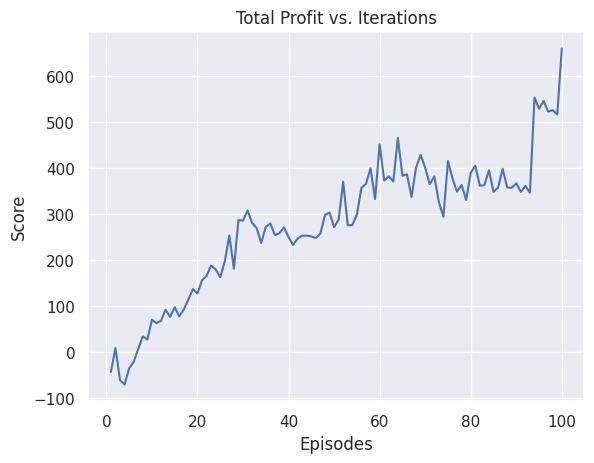

In [21]:
tf.compat.v1.disable_eager_execution()

close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size,
              window_size = window_size,
              trend = close,
              skip = skip,
              batch_size = batch_size)
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

# Run the evaluation

In [30]:
states_buy, states_sell, total_gains, invest = agent.evaluate(initial_money = initial_money)

day 1015: buy 1 unit at price 158.279999, total balance 9841.561721
day 1016, sell 1 unit at price 157.649994, investment -0.597037 %, total balance 9999.054065,
day 1018: buy 1 unit at price 162.360001, total balance 9836.531705
day 1021: buy 1 unit at price 165.630005, total balance 9670.736070
day 1022, sell 1 unit at price 163.759995, investment 0.660755 %, total balance 9834.332304,
day 1023, sell 1 unit at price 164.660004, investment -0.784274 %, total balance 9998.827648,
day 1024: buy 1 unit at price 162.029999, total balance 9836.635619
day 1025: buy 1 unit at price 160.800003, total balance 9675.674816
day 1026: buy 1 unit at price 160.100006, total balance 9515.414710
day 1030, sell 1 unit at price 166.470001, investment 2.534960 %, total balance 9681.718241,
day 1033: buy 1 unit at price 165.020004, total balance 9516.533217
day 1034, sell 1 unit at price 165.330002, investment 2.611734 %, total balance 9681.697889,
day 1035, sell 1 unit at price 163.770004, investment 2.0

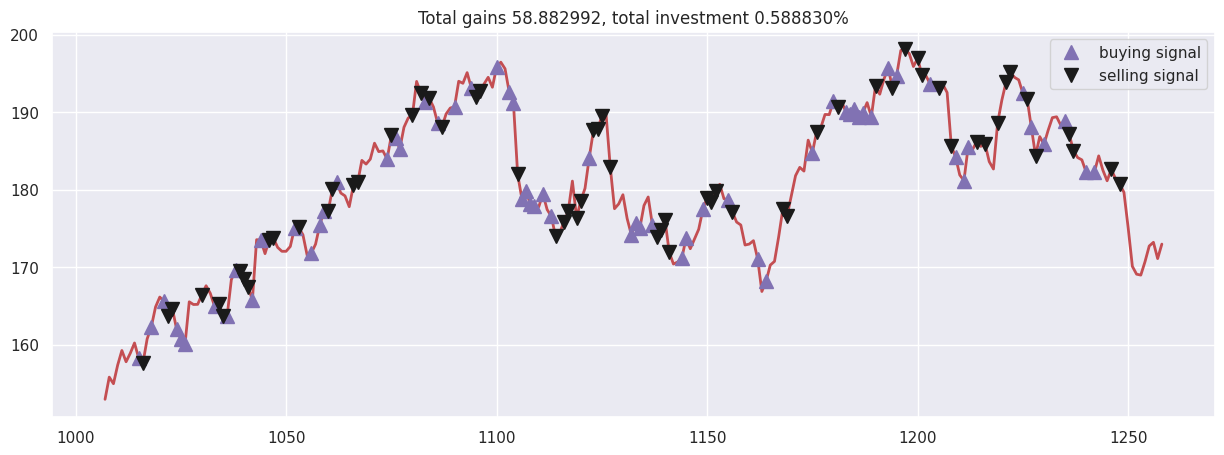

In [31]:
fig = plt.figure(figsize=(15, 5))

slice_index = round(0.8 * len(close))
states_buy_adjusted = [state - slice_index for state in states_buy]
states_sell_adjusted = [state - slice_index for state in states_sell]

plt.plot(range(slice_index, len(close)), close[slice_index:], color='r', lw=2.)
plt.plot(range(slice_index, len(close)), close[slice_index:], '^', markersize=10, color='m', label='buying signal', markevery=states_buy_adjusted)
plt.plot(range(slice_index, len(close)), close[slice_index:], 'v', markersize=10, color='k', label='selling signal', markevery=states_sell_adjusted)
plt.title('Total gains %f, total investment %f%%' % (total_gains, invest))
plt.legend()
plt.show()